<h1>Titanic Exploratory Data Analysis</h1><br>
<strong>author:</strong> Zen Yui<br>
<strong>date: </strong>2016-01-08
<hr>

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from __future__ import division

In [2]:
#set plotting to 'ggplot' style
plt.style.use('ggplot')

In [3]:
# import data from csv into dataframe 'df'
df = pd.read_csv('titanic.csv', index_col=0, header=0)
df.index.names = ['id']

In [4]:
df.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
id,,,,,,,,,,,
887,0,2,"Montvila, Rev. Juozas",male,27,0,0,211536,13.00,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19,0,0,112053,30.00,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
890,1,1,"Behr, Mr. Karl Howell",male,26,0,0,111369,30.00,C148,C
891,0,3,"Dooley, Mr. Patrick",male,32,0,0,370376,7.75,NaN,Q


<hr>
<h1>Problems with the data</h1>
<ul>
    <li>Missing Age values (~20%)</li>
    <li>Missing Cabin values (~77%)</li>
    <li>Missing Embarked values (2 records)</li>
</ul>

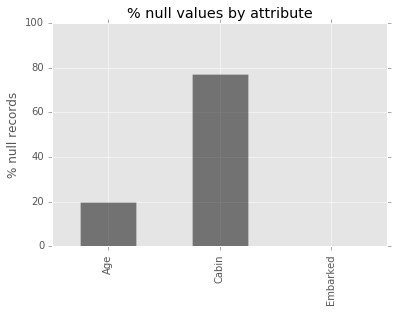

In [5]:
# dividing sum of null values (where null == 1) by count of all values
ldf = len(df)
na = df.isnull().sum() / ldf * 100
na[na>0].plot(kind='bar', ylim=(0,100), color='k', alpha=0.5)
plt.title('% null values by attribute')
plt.ylabel('% null records');

<h3>Missing ages can be filled with the median age of that Sex and Class</h3>

In [6]:
# calculate median age by Sex and Pclass, and fill missing Ages with these values.

medage = df[df.Age.isnull()==False].groupby(['Sex','Pclass']).Age.median()
get_age = lambda x: medage[x['Sex'],x['Pclass']]
df['Age'].fillna(df[df['Age'].isnull()].apply(get_age, axis=1), inplace=True)

<h3>Only 2 rows missing 'Embarked' value, so rows are dropped</h3>

In [7]:
# drop rows where 'Embarked' is null
df.dropna(subset=['Embarked'], inplace=True)

<h3>Too many values missing from Cabin, so whole column is dropped</h3>

In [8]:
# drop 'Cabin' column
df.drop(['Cabin'], axis=1, inplace=True)

<hr>
<h1>Overall survival rate</h1>

Overall survival rate is ~38%

In [9]:
# divide sum of survived passengers by count of all passengers
df.Survived.sum() / df.Survived.count() * 100

38.245219347581553

<hr>
<H1>Helper function for determining survival relationship</H1>
<h3>Function "get_srate" below aggregates titanic dataframe to understand the impact of the combination of passenger attributes on survival.</h3>

In [10]:
# dictionary and list used for crosstabs and column sorting
sdict = {1: 'Survived',0:'Deceased'}
slist = ['Survived','Deceased']

In [11]:
# define function 'get_srate' for easier analysis of attributes and survival
def get_srate(df, col_list):
    """Given a dataframe and list of groupby columns,
    return a crosstab dataframe of Survivors, Deceased,
    and survival rate
    """
    ct = pd.crosstab([df[col] for col in col_list], df['Survived'].map(sdict))[slist]
    ct['PassengerCount'] = ct['Survived'] + ct['Deceased']
    ct['PercentOfTotal'] = ct['PassengerCount'] / ct['PassengerCount'].sum() * 100
    ct['PercentOfSurvivors'] = ct['Survived'] / ct['Survived'].sum() * 100
    ct['PercentOfDeceased'] = ct['Deceased'] / ct['Deceased'].sum() * 100
    ct['SurvivalRate'] = (ct['Survived'] / ct['PassengerCount'] * 100).astype(float)
    ct.columns.name=None
    return ct

<hr>
<H1>Gender as a survival predictor</H1>
<h3>Female passengers are more likely to survive.  Female survivors also outnumber male survivors despite there being more male passengers onboard.</h3>

In [12]:
# get crosstab of Sex and Survived
ct = get_srate(df, ['Sex'])
ct

,Survived,Deceased,PassengerCount,PercentOfTotal,PercentOfSurvivors,PercentOfDeceased,SurvivalRate
Sex,,,,,,,
female,231,81,312,35.095613,67.941176,14.754098,74.038462
male,109,468,577,64.904387,32.058824,85.245902,18.890815


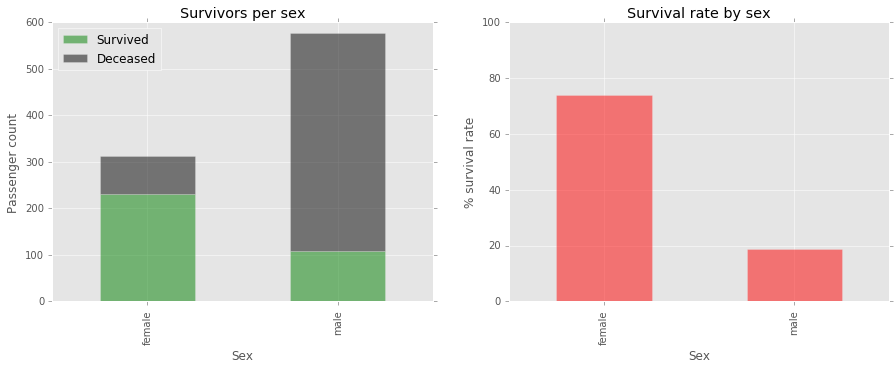

In [13]:
# graph survival rate by gender
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ct[['Survived','Deceased']].plot(kind='bar', stacked=True, alpha=.5, color=['green','k'], ax=axes[0], title='Survivors per sex')
axes[0].set_ylabel('Passenger count')

ct[['SurvivalRate']].plot(kind='bar', alpha=.5, color='red', ax=axes[1], ylim=(0,100), title='Survival rate by sex', legend=False)
axes[1].set_ylabel('% survival rate');

<h1>Class as a survival predictor</h1>
<h3><ul>
    <li>62.6% of first class passengers survived</li>
    <li>47.3% of second class passengers survived</li>
    <li>24.3% of third class passengers survived</li>
</ul></h3>

In [14]:
# create a frequency table survival per class and calculate survival rate as a percentage
ct = get_srate(df, ['Pclass'])
ct

,Survived,Deceased,PassengerCount,PercentOfTotal,PercentOfSurvivors,PercentOfDeceased,SurvivalRate
Pclass,,,,,,,
1,134,80,214,24.071991,39.411765,14.571949,62.616822
2,87,97,184,20.697413,25.588235,17.668488,47.282609
3,119,372,491,55.230596,35.000000,67.759563,24.236253


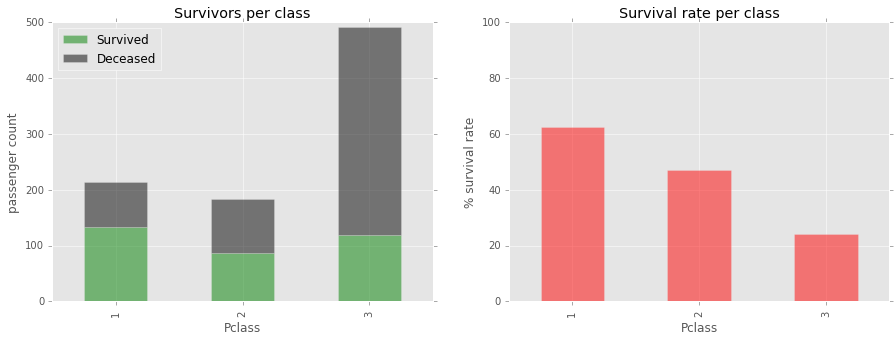

In [15]:
# graph survival by class
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ct[['Survived','Deceased']].plot(kind='bar', stacked=True, alpha=.5, color=['green','k'], grid=True, ax=axes[0], title='Survivors per class')
axes[0].set_ylabel('passenger count')

ct['SurvivalRate'].plot(kind='bar', alpha=0.5, color='r', ylim=(0,100), ax=axes[1], title='Survival rate per class')
axes[1].set_ylabel('% survival rate');

<h1>Age as an indicator of survival</h1>
<h3>Age is not a definitive survival indicator on its own:<br>

<ul>
<li>61.3% of children below the age of 10 survive</li>
<li>There is an 80-year-old that survived, but this is not a large enough sample</li>
<li>None of the adults from 70-79 survived
</ul></h3>

In [16]:
# Group ages into 10-year increments
df['AgeGroup'] = df.Age.apply(lambda x: int(x / 10) * 10).astype(int)

In [17]:
# create a frequency table survival per class and calculate survival rate as a percentage
ct = get_srate(df, ['AgeGroup'])
ct

,Survived,Deceased,PassengerCount,PercentOfTotal,PercentOfSurvivors,PercentOfDeceased,SurvivalRate
AgeGroup,,,,,,,
0,38,24,62,6.974128,11.176471,4.371585,61.290323
10,41,61,102,11.473566,12.058824,11.111111,40.196078
20,113,245,358,40.269966,33.235294,44.626594,31.564246
30,83,101,184,20.697413,24.411765,18.397086,45.108696
40,39,71,110,12.373453,11.470588,12.932605,35.454545
50,20,28,48,5.399325,5.882353,5.100182,41.666667
60,5,13,18,2.024747,1.470588,2.367942,27.777778
70,0,6,6,0.674916,0.000000,1.092896,0.000000
80,1,0,1,0.112486,0.294118,0.000000,100.000000


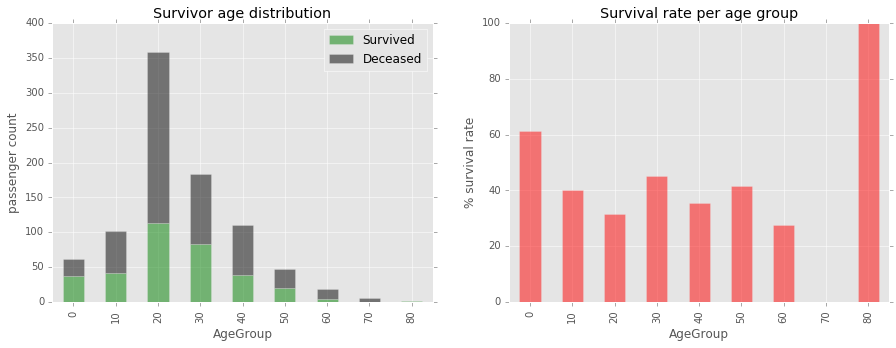

In [18]:
# graph survival by age
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ct[['Survived','Deceased']].plot(kind='bar', stacked=True, alpha=.5, color=['green','k'], grid=True, ax=axes[0], title='Survivor age distribution')
axes[0].set_ylabel('passenger count')

ct['SurvivalRate'].plot(kind='bar', alpha=0.5, color='r', ylim=(0,100), ax=axes[1], title='Survival rate per age group')
axes[1].set_ylabel('% survival rate');

<hr>
<h1>Overall predictors of survival</h1>

<h3>
Sex and class together are strong indicators of survival:<br>
<ul>
<li>1st and 2nd class women have 96.7% and 92.1% survival rates, respectively.</li>
<li>1st class men have a 36.9% survival rate (over double that of 2nd or 3rd class)</li>
<li>3rd class men have the lowest surviavl rate (13.5%) and the highest casualty count (300 passengers)

</h3>

In [19]:
# frequency table of survivors by sex & class
ct = get_srate(df, ['Sex','Pclass'])
ct

Survived  Deceased  PassengerCount  PercentOfTotal  \
Sex    Pclass                                                       
female 1             89         3              92       10.348706   
       2             70         6              76        8.548931   
       3             72        72             144       16.197975   
male   1             45        77             122       13.723285   
       2             17        91             108       12.148481   
       3             47       300             347       39.032621   

               PercentOfSurvivors  PercentOfDeceased  SurvivalRate  
Sex    Pclass                                                       
female 1                26.176471           0.546448     96.739130  
       2                20.588235           1.092896     92.105263  
       3                21.176471          13.114754     50.000000  
male   1                13.235294          14.025501     36.885246  
       2                 5.000000          16.575592     15.740741  
       3                13.823529          54.644809     13.544669

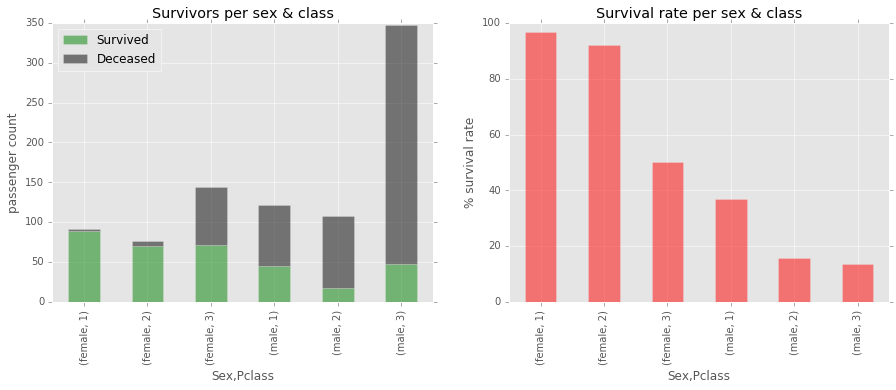

In [20]:
# graph survival by age
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

ct[['Survived','Deceased']].plot(kind='bar', stacked=True, alpha=.5, color=['green','k'], grid=True, ax=axes[0], title='Survivors per sex & class')
axes[0].set_ylabel('passenger count')

ct['SurvivalRate'].plot(kind='bar', alpha=0.5, color='r', ylim=(0,100), ax=axes[1], title='Survival rate per sex & class')
axes[1].set_ylabel('% survival rate');

<h3>
Sex and age together reveal interesting survival rates:<br>
<ul>
    <li>Women in their 20's are the single largest group of survivors (23% of survivors)</li>
    <li>Men in their 20's account for 37.9% of deceased passengers, the single largest group</li>
</ul>
</h3>

In [21]:
# frequency table of survivors by sex & age
ct = get_srate(df, ['Sex','AgeGroup'])
ct

Survived  Deceased  PassengerCount  PercentOfTotal  \
Sex    AgeGroup                                                       
female 0               19        11              30        3.374578   
       10              34        11              45        5.061867   
       20              79        37             116       13.048369   
       30              58        10              68        7.649044   
       40              22        10              32        3.599550   
       50              16         2              18        2.024747   
       60               3         0               3        0.337458   
male   0               19        13              32        3.599550   
       10               7        50              57        6.411699   
       20              34       208             242       27.221597   
       30              25        91             116       13.048369   
       40              17        61              78        8.773903   
       50               4        26              30        3.374578   
       60               2        13              15        1.687289   
       70               0         6               6        0.674916   
       80               1         0               1        0.112486   

                 PercentOfSurvivors  PercentOfDeceased  SurvivalRate  
Sex    AgeGroup                                                       
female 0                   5.588235           2.003643     63.333333  
       10                 10.000000           2.003643     75.555556  
       20                 23.235294           6.739526     68.103448  
       30                 17.058824           1.821494     85.294118  
       40                  6.470588           1.821494     68.750000  
       50                  4.705882           0.364299     88.888889  
       60                  0.882353           0.000000    100.000000  
male   0                   5.588235           2.367942     59.375000  
       10                  2.058824           9.107468     12.280702  
       20                 10.000000          37.887067     14.049587  
       30                  7.352941          16.575592     21.551724  
       40                  5.000000          11.111111     21.794872  
       50                  1.176471           4.735883     13.333333  
       60                  0.588235           2.367942     13.333333  
       70                  0.000000           1.092896      0.000000  
       80                  0.294118           0.000000    100.000000

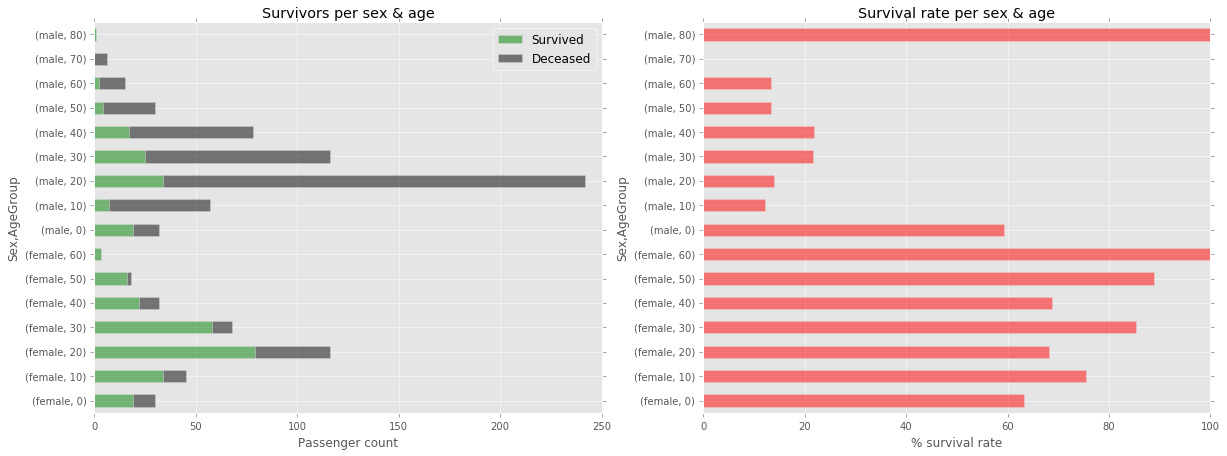

In [22]:
# graph survival by sex & age
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ct[['Survived','Deceased']].plot(kind='barh', stacked=True, alpha=.5, color=['green','k'], grid=True, ax=axes[0], title='Survivors per sex & age')
axes[0].set_xlabel('Passenger count')

ct['SurvivalRate'].plot(kind='barh', alpha=0.5, color='r', xlim=(0,100), ax=axes[1], title='Survival rate per sex & age')
axes[1].set_xlabel('% survival rate');

<h3>The combination of Sex, Age, and Class are strong indicators of survival:<br>
<ul>
    <li>96.7% of 1st class women surive</li>
    <ul>
        <li>100% of ages 10-19 and 30-49 survive</li>
        <li>93.8% of ages 20-29 survive</li>
    </ul>
    <br>
    
    <li>92.1% of 2nd class women survive</li>
    <ul>
        <li>100% of ages 0-19 survive</li>
        <li>94.1% of ages 30-39 survive</li>
        <li>90% of ages 40-49 survive</li>
    </ul>
    <br>
    <li>100% of boys ages 0-9 survived (9 passengers)</li>
</ul>
</h3>

In [23]:
# frequency table of survivors by sex & age & class
ct = get_srate(df, ['Sex','AgeGroup','Pclass'])

# filter for groups over 5 passengers with a survival rate over 80%
ct2 = ct[(ct.PassengerCount>5) & (ct.SurvivalRate > 80)].sort_values(by=['SurvivalRate'], ascending=True)
ct2.sort_values(by=['SurvivalRate'], ascending=False)

Survived  Deceased  PassengerCount  PercentOfTotal  \
Sex    AgeGroup Pclass                                                       
female 0        2              8         0               8        0.899888   
       10       1             13         0              13        1.462317   
                2              8         0               8        0.899888   
       30       1             35         0              35        3.937008   
       40       1             13         0              13        1.462317   
male   0        2              9         0               9        1.012373   
female 30       2             16         1              17        1.912261   
       20       1             15         1              16        1.799775   
       50       1             11         1              12        1.349831   
       40       2              9         1              10        1.124859   
       20       2             24         3              27        3.037120   
       50       2              5         1               6        0.674916   

                        PercentOfSurvivors  PercentOfDeceased  SurvivalRate  
Sex    AgeGroup Pclass                                                       
female 0        2                 2.352941           0.000000    100.000000  
       10       1                 3.823529           0.000000    100.000000  
                2                 2.352941           0.000000    100.000000  
       30       1                10.294118           0.000000    100.000000  
       40       1                 3.823529           0.000000    100.000000  
male   0        2                 2.647059           0.000000    100.000000  
female 30       2                 4.705882           0.182149     94.117647  
       20       1                 4.411765           0.182149     93.750000  
       50       1                 3.235294           0.182149     91.666667  
       40       2                 2.647059           0.182149     90.000000  
       20       2                 7.058824           0.546448     88.888889  
       50       2                 1.470588           0.182149     83.333333

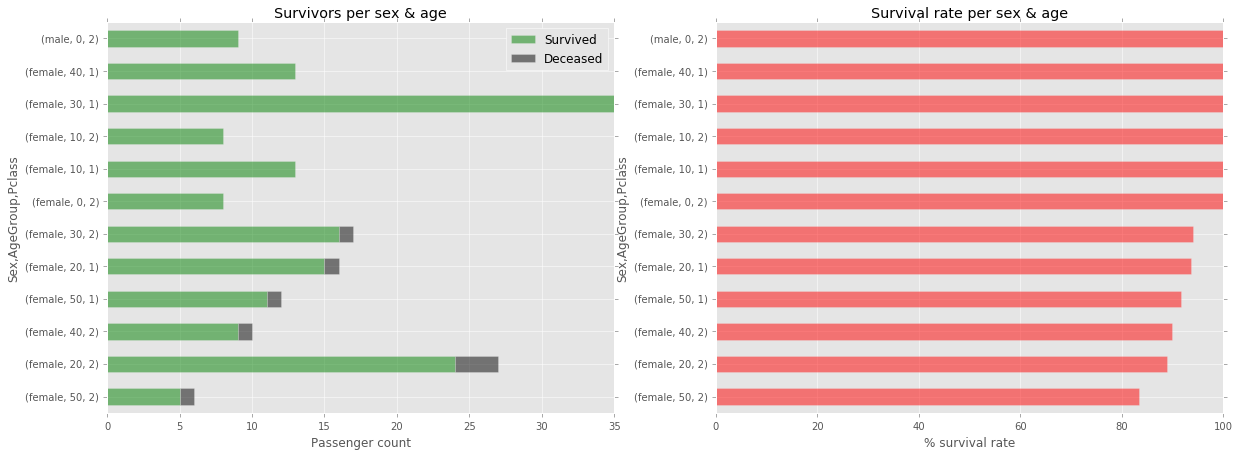

In [24]:
# graph survival by age
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ct2[['Survived','Deceased']].plot(kind='barh', stacked=True, alpha=.5, color=['green','k'], grid=True, ax=axes[0], title='Survivors per sex & age')
axes[0].set_xlabel('Passenger count')

ct2['SurvivalRate'].plot(kind='barh', alpha=0.5, color='r', xlim=(0,100), ax=axes[1], title='Survival rate per sex & age')
axes[1].set_xlabel('% survival rate');

<hr>
<h1>New features that could determine survival</h1>

<h3>
'HasFam' (Has Family) yields 1 when the passenger has siblings, spouses, parents, or children on board<br>
<ul>
<li>Women without family were the largest group of all survivors</li>
<li>Men with family were more likely to survive than men without family</li>
</h3>

In [25]:
# create column 'HasFam' that yiels 1 when the passenger has SibSp==1 AND Parch==1
df['HasFam'] = ((df.SibSp==1) & (df.Parch==1)).astype(int)
ct = get_srate(df, ['Sex','HasFam'])
ct

Survived  Deceased  PassengerCount  PercentOfTotal  \
Sex    HasFam                                                       
female 0            211        75             286       32.170979   
       1             20         6              26        2.924634   
male   0             95       451             546       61.417323   
       1             14        17              31        3.487064   

               PercentOfSurvivors  PercentOfDeceased  SurvivalRate  
Sex    HasFam                                                       
female 0                62.058824          13.661202     73.776224  
       1                 5.882353           1.092896     76.923077  
male   0                27.941176          82.149362     17.399267  
       1                 4.117647           3.096539     45.161290

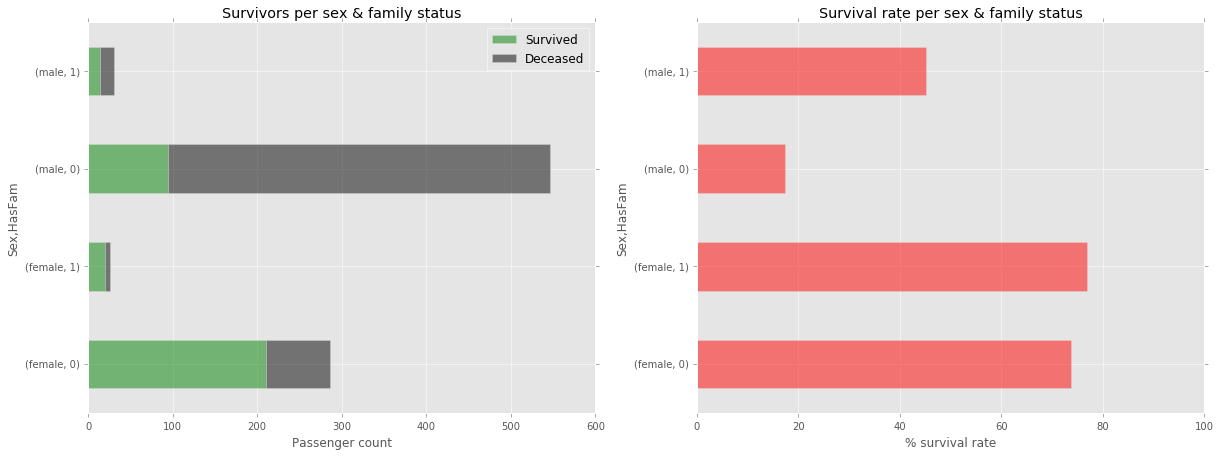

In [26]:
# graph survival by sex & age
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ct[['Survived','Deceased']].plot(kind='barh', stacked=True, alpha=.5, color=['green','k'], grid=True, ax=axes[0], title='Survivors per sex & family status')
axes[0].set_xlabel('Passenger count')

ct['SurvivalRate'].plot(kind='barh', alpha=0.5, color='r', xlim=(0,100), ax=axes[1], title='Survival rate per sex & family status')
axes[1].set_xlabel('% survival rate');

<h3>
'TitleGroup' (Mr, Miss, Mrs, Master, Other) grouping derived from the 'Name' column

</h3>

In [27]:
# extract titles from name, find those beloning to at least 4% of passengers
df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()
TitleCounts = df['Title'].value_counts() / len(df) * 100
TitleCounts[TitleCounts>4]

Mr        58.155231
Miss      20.359955
Mrs       13.948256
Master     4.499438
Name: Title, dtype: float64

In [28]:
# group titles into groups consisting of over 4% of all passengers
df['TitleGroup'] = df['Title'].map({'Mr':'Mr','Miss':'Miss','Mrs':'Mrs','Master':'Master'}).fillna('Other')
df.drop('Title', axis=1, inplace=True)
ct = get_srate(df, ['Sex','TitleGroup'])

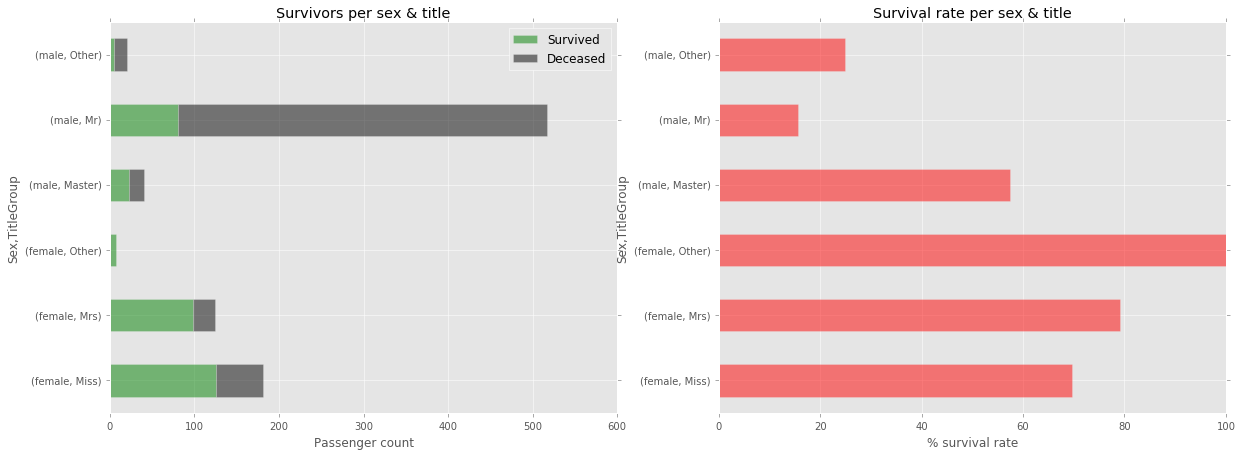

In [29]:
# graph survival by sex & title
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 7))

ct[['Survived','Deceased']].plot(kind='barh', stacked=True, alpha=.5, color=['green','k'], grid=True, ax=axes[0], title='Survivors per sex & title')
axes[0].set_xlabel('Passenger count')

ct['SurvivalRate'].plot(kind='barh', alpha=0.5, color='r', xlim=(0,100), ax=axes[1], title='Survival rate per sex & title')
axes[1].set_xlabel('% survival rate');